In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_float32_matmul_precision('medium')
from PIL import Image
from tqdm import tqdm
from itertools import combinations_with_replacement

# Select GPU device for the training if available
if not torch.cuda.is_available():
    device = torch.device("cpu")
    print("Current device:", device)
else:
    device = torch.device("cuda")
    print(
        "devices available:",
        [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())],
    )
    print("Current device:", device, "- Type:", torch.cuda.get_device_name(0))

n_classes = 104

devices available: ['NVIDIA GeForce RTX 4090']
Current device: cuda - Type: NVIDIA GeForce RTX 4090


In [30]:
# 初始化共现矩阵
co_occurrence_matrix = np.zeros((n_classes, n_classes), dtype=np.int32)

# 数据路径
ann_dir_train = "/tmp/FoodSeg103-256/Images/ann_dir/train/"

# 遍历标签文件
for ann_file in tqdm(os.listdir(ann_dir_train)):
    # 构造完整路径
    ann_path = os.path.join(ann_dir_train, ann_file)

    # 加载标签图像
    label_img = Image.open(ann_path)
    label_array = np.array(label_img)

    # 找到唯一类别
    unique_labels = np.unique(label_array)

    # 使用组合计算类别共现
    for c1, c2 in combinations_with_replacement(unique_labels, 2):
        co_occurrence_matrix[c1, c2] += 1
        if c1 != c2:
            co_occurrence_matrix[c2, c1] += 1


print(co_occurrence_matrix)
np.save("co-occur.npy", co_occurrence_matrix)

100%|██████████| 4983/4983 [00:04<00:00, 1195.86it/s]

[[4982   21    3 ...   99   12  155]
 [  21   21    0 ...    0    0    1]
 [   3    0    3 ...    0    0    0]
 ...
 [  99    0    0 ...   99    0    3]
 [  12    0    0 ...    0   12    0]
 [ 155    1    0 ...    3    0  155]]


In [31]:
# 初始化类别计数（记录每个类别出现过的图像数量）
class_image_counts = np.zeros(n_classes, dtype=np.int64)

# 标签文件目录
ann_dir_train = "/tmp/FoodSeg103-256/Images/ann_dir/train/"

# 遍历标签文件
for ann_file in tqdm(os.listdir(ann_dir_train)):
    # 构造完整路径
    ann_path = os.path.join(ann_dir_train, ann_file)

    # 加载标签图像
    label_img = Image.open(ann_path)
    label_array = np.array(label_img)

    # 获取图像中出现的唯一类别
    unique_labels = np.unique(label_array)

    # 对这些类别计数（每个类别在此图像中出现过）
    for label in unique_labels:
        class_image_counts[label] += 1

# 计算类别出现的频率（相对于总图像数）
total_images = len(os.listdir(ann_dir_train))
class_frequencies = class_image_counts / total_images

# 输出类别频率
print("Class Frequencies:", class_frequencies)

100%|██████████| 4983/4983 [00:03<00:00, 1245.78it/s]

Class Frequencies: [9.99799318e-01 4.21432872e-03 6.02046960e-04 3.33132651e-02
 9.83343367e-03 4.37487457e-02 2.00682320e-03 8.02729280e-04
 1.27633955e-01 5.53883203e-02 6.68272125e-02 1.92655027e-02
 1.60545856e-02 2.54866546e-02 2.58880193e-02 9.03070439e-03
 4.81637568e-03 1.40477624e-02 4.01364640e-03 2.60887016e-03
 3.61228176e-03 6.42183424e-03 8.22797512e-03 1.40477624e-03
 4.47521573e-02 2.12723259e-02 1.40477624e-03 4.41501104e-03
 1.14388922e-02 2.00682320e-02 7.78647401e-02 3.19084889e-02
 3.05037126e-02 9.43206903e-03 8.62933976e-03 8.62933976e-03
 1.46498094e-02 8.48886213e-02 6.02046960e-03 4.21432872e-03
 1.88641381e-02 2.46839253e-02 7.62592816e-03 4.01364640e-03
 3.67248645e-02 5.81978728e-03 1.46096729e-01 9.51234196e-02
 1.70178607e-01 3.93337347e-02 3.09050773e-02 1.42484447e-02
 1.64158138e-01 2.80955248e-03 5.17760385e-02 6.02046960e-03
 1.98675497e-02 1.34457154e-02 1.98876179e-01 6.88340357e-02
 1.00341160e-03 1.08368453e-02 3.81296408e-03 1.80614088e-03
 2.28

In [32]:
# 对共现矩阵进行倒数修正
epsilon = 1e-6
adjusted_co_matrix = co_occurrence_matrix / (
    class_frequencies[:, None] + class_frequencies[None, :] + epsilon
)
tau = 600  # 设置最大共现值
clipped_co_matrix = np.minimum(adjusted_co_matrix, tau)
adjusted_co_matrix = np.sqrt(clipped_co_matrix)

# 输出修正后的共现矩阵
print("Adjusted Co-occurrence Matrix:")
print(adjusted_co_matrix)

Adjusted Co-occurrence Matrix:
[[24.49489743  4.57340459  1.73170245 ...  9.85344803  3.4602827
  12.26185847]
 [ 4.57340459 24.49489743  0.         ...  0.          0.
   5.32087384]
 [ 1.73170245  0.         24.49489743 ...  0.          0.
   0.        ]
 ...
 [ 9.85344803  0.          0.         ... 24.49489743  0.
   7.67158237]
 [ 3.4602827   0.          0.         ...  0.         24.49489743
   0.        ]
 [12.26185847  5.32087384  0.         ...  7.67158237  0.
  24.49489743]]


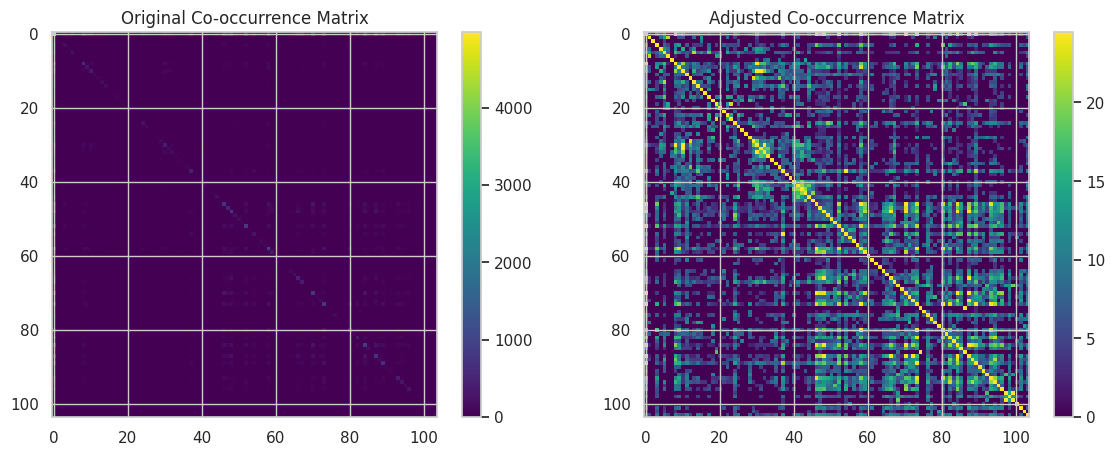

In [33]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.imshow(co_occurrence_matrix, cmap="viridis")
plt.title("Original Co-occurrence Matrix")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(adjusted_co_matrix, cmap="viridis")
plt.title("Adjusted Co-occurrence Matrix")
plt.colorbar()

plt.show()

In [ ]:
# np.save("adjusted-occurrence.npy", adjusted_co_matrix)
np.save("occurrence-food103.npy", adjusted_co_matrix)

In [35]:
adjusted_co_matrix = np.load("occurrence-food103.npy")

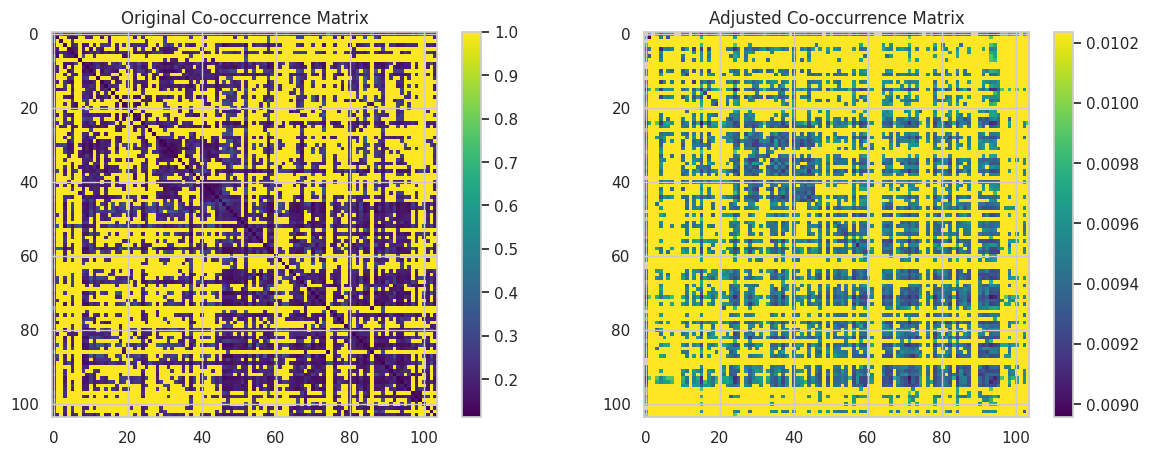

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

matrix_103 = np.load("occurrence-food103.npy")
matrix_1m = np.load("occurrence-recipe1M.npy")

plt.figure(figsize=(14, 5))
sns.set(style="whitegrid")

plt.subplot(1, 2, 1)
plt.imshow(matrix_103, cmap="viridis")
plt.title("Original Co-occurrence Matrix")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(matrix_1m, cmap="viridis")
plt.title("Adjusted Co-occurrence Matrix")
plt.colorbar()

plt.show()